# Multiclass classification with Amazon SageMaker XGBoost algorithm
_**Single machine and distributed training for multiclass classification with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data conversion](#Data-conversion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
  1. [Training on a single instance](#Training-on-a-single-instance)
  2. [Training on multiple instances](#Training-on-multiple-instances)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction


This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a multiclass classification model. The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset is used for training. It has a training set of 60,000 examples and a test set of 10,000 examples. To illustrate the use of libsvm training data format, we download the dataset and convert it to the libsvm format before training.

To get started, we need to set up the environment with a few prerequisites for permissions and configurations.

---
## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services.

1. The roles used to give learning and hosting access to your data. See the documentation for how to specify these.
2. The S3 bucket that you want to use for training and model data.

In [1]:
%%time

import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='fab-sagemaker' # put your s3 bucket name here, and create s3 bucket

CPU times: user 746 ms, sys: 80.2 ms, total: 826 ms
Wall time: 1.88 s


In [2]:
role

'arn:aws:iam::640463227255:role/service-role/AmazonSageMaker-ExecutionRole-20200822T102773'

In [3]:
prefix = 'xgboost-mnist/DEMO-xgboost-multiclass-classification'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
bucket_path

'https://s3-us-east-1.amazonaws.com/fab-sagemaker'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [4]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

CPU times: user 864 ms, sys: 304 ms, total: 1.17 s
Wall time: 1.69 s


In [9]:
type(train_set)

tuple

In [12]:
train_set[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the data is converted from pickle-ized numpy array to the libsvm format before being uploaded to S3. The hosted implementation of xgboost consumes the libsvm converted data from S3 for training. The following provides functions for data conversions and file upload to S3 and download from S3. 

In [13]:
%%time

import struct
import io
import boto3

 
def to_libsvm(f, labels, values):
     f.write(bytes('\n'.join(
         ['{} {}'.format(label, ' '.join(['{}:{}'.format(i + 1, el) for i, el in enumerate(vec)])) for label, vec in
          zip(labels, values)]), 'utf-8'))
     return f


def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def get_dataset():
  import pickle
  import gzip
  with gzip.open('mnist.pkl.gz', 'rb') as f:
      u = pickle._Unpickler(f)
      u.encoding = 'latin1'
      return u.load()

def upload_to_s3(partition_name, partition):
    labels = [t.tolist() for t in partition[1]]
    vectors = [t.tolist() for t in partition[0]]
    num_partition = 5                                 # partition file into 5 parts
    partition_bound = int(len(labels)/num_partition)
    for i in range(num_partition):
        f = io.BytesIO()
        to_libsvm(f, labels[i*partition_bound:(i+1)*partition_bound], vectors[i*partition_bound:(i+1)*partition_bound])
        f.seek(0)
        key = "{}/{}/examples{}".format(prefix,partition_name,str(i))
        url = 's3://{}/{}'.format(bucket, key)
        print('Writing to {}'.format(url))
        write_to_s3(f, bucket, key)
        print('Done writing to {}'.format(url))

def download_from_s3(partition_name, number, filename):
    key = "{}/{}/examples{}".format(prefix,partition_name, number)
    url = 's3://{}/{}'.format(bucket, key)
    print('Reading from {}'.format(url))
    s3 = boto3.resource('s3', region_name = region)
    s3.Bucket(bucket).download_file(key, filename)
    try:
        s3.Bucket(bucket).download_file(key, 'mnist.local.test')
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print('The object does not exist at {}.'.format(url))
        else:
            raise        
        
def convert_data():
    train_set, valid_set, test_set = get_dataset()
    partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for partition_name, partition in partitions:
        print('{}: {} {}'.format(partition_name, partition[0].shape, partition[1].shape))
        upload_to_s3(partition_name, partition)

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 15 µs


In [14]:
%%time

convert_data()

train: (50000, 784) (50000,)
Writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples0
Done writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples0
Writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples1
Done writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples1
Writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples2
Done writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples2
Writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples3
Done writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples3
Writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/train/examples4
Done writing to s3://fab-sagemaker/xgboost-mnist/DEMO-xgboos

## Training the XGBoost model

Now that we have our data in S3, we can begin training. We'll use Amazon SageMaker XGboost algorithm, and will actually fit two models in order to demonstrate the single machine and distributed training on SageMaker. In the first job, we'll use a single machine to train. In the second job, we'll use two machines and use the ShardedByS3Key mode for the train channel. Since we have 5 part file, one machine will train on three and the other on two part files. Note that the number of instances should not exceed the number of part files. 

First let's setup a list of training parameters which are common across the two jobs.

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [16]:
#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.10xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "10",
        "num_round": "10"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "libsvm",
            "CompressionType": "None"
        }
    ]
}

Now we'll create two separate jobs, updating the parameters that are unique to each.

### Training on a single instance

In [18]:
#single machine job params
single_machine_job_name = 'DEMO-xgboost-classification' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", single_machine_job_name)

single_machine_job_params = copy.deepcopy(common_training_params)
single_machine_job_params['TrainingJobName'] = single_machine_job_name
single_machine_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/"+ prefix + "/xgboost-single"
single_machine_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: DEMO-xgboost-classification2020-09-27-18-47-49


### Training on multiple instances

You can also run the training job distributed over multiple instances. For larger datasets with multiple partitions, this can significantly boost the training speed. Here we'll still use the small/toy MNIST dataset to demo this feature.

In [19]:
#distributed job params
distributed_job_name = 'DEMO-xgboost-distrib-classification' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", distributed_job_name)

distributed_job_params = copy.deepcopy(common_training_params)
distributed_job_params['TrainingJobName'] = distributed_job_name
distributed_job_params['OutputDataConfig']['S3OutputPath'] = bucket_path + "/"+ prefix + "/xgboost-distributed"
#number of instances used for training
distributed_job_params['ResourceConfig']['InstanceCount'] = 2 # no more than 5 if there are total 5 partition files generated above

# data distribution type for train channel
distributed_job_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'
# data distribution type for validation channel
distributed_job_params['InputDataConfig'][1]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

Job name is: DEMO-xgboost-distrib-classification2020-09-27-18-47-53


Let's submit these jobs, taking note that the first will be submitted to run in the background so that we can immediately run the second in parallel.

In [20]:
%%time

sm = boto3.Session(region_name=region).client('sagemaker')

sm.create_training_job(**single_machine_job_params)
sm.create_training_job(**distributed_job_params)

status = sm.describe_training_job(TrainingJobName=distributed_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=distributed_job_name)
status = sm.describe_training_job(TrainingJobName=distributed_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=distributed_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 164 ms, sys: 13.8 ms, total: 178 ms
Wall time: 8min 2s


Let's confirm both jobs have finished.

In [21]:
print('Single Machine:', sm.describe_training_job(TrainingJobName=single_machine_job_name)['TrainingJobStatus'])
print('Distributed:', sm.describe_training_job(TrainingJobName=distributed_job_name)['TrainingJobStatus'])

Single Machine: Completed
Distributed: Completed


# Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. The step below demonstrated hosting the model generated from the distributed training job. Same steps can be followed to host the model obtained from the single machine job. 

### Import model into hosting
Next, you register the model with hosting. This allows you the flexibility of importing models trained elsewhere.

In [22]:
%%time
import boto3
from time import gmtime, strftime

model_name=distributed_job_name + '-mod'
print(model_name)

info = sm.describe_training_job(TrainingJobName=distributed_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

DEMO-xgboost-distrib-classification2020-09-27-18-47-53-mod
https://s3-us-east-1.amazonaws.com/fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/xgboost-distributed/DEMO-xgboost-distrib-classification2020-09-27-18-47-53/output/model.tar.gz
arn:aws:sagemaker:us-east-1:640463227255:model/demo-xgboost-distrib-classification2020-09-27-18-47-53-mod
CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 505 ms


### Create endpoint configuration
SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [23]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-09-27-19-01-15
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:640463227255:endpoint-config/demo-xgboostendpointconfig-2020-09-27-19-01-15


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [24]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-09-27-19-01-32
arn:aws:sagemaker:us-east-1:640463227255:endpoint/demo-xgboostendpoint-2020-09-27-19-01-32
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:640463227255:endpoint/demo-xgboostendpoint-2020-09-27-19-01-32
Status: InService
CPU times: user 153 ms, sys: 963 µs, total: 154 ms
Wall time: 8min 1s


## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [25]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

In order to evaluate the model, we'll use the test dataset previously generated. Let us first download the data from S3 to the local host.

In [26]:
download_from_s3('test', 0, 'mnist.local.test') # reading the first part file within test

Reading from s3://fab-sagemaker/xgboost-mnist/DEMO-xgboost-multiclass-classification/test/examples0


Start with a single prediction. Lets use the first record from the test file.

In [27]:
!head -1 mnist.local.test > mnist.single.test

In [28]:
%%time
import json

file_name = 'mnist.single.test' #customize to your test file 'mnist.single.test' if use the data above

with open(file_name, 'r') as f:
    payload = f.read()

response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read().decode('ascii')
print('Predicted label is {}.'.format(result))

Predicted label is 7.0.
CPU times: user 11.7 ms, sys: 4.15 ms, total: 15.9 ms
Wall time: 154 ms


OK, a single prediction works.
Let's do a whole batch and see how good is the predictions accuracy.

In [29]:
import sys
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read().decode('ascii')
    preds = [float(num) for num in result.split(',')]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items, batch_size):
        arrs.extend(do_predict(data[offset:min(offset+batch_size, items)], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

The following function helps us calculate the error rate on the batch dataset. 

In [30]:
%%time
import json

file_name = 'mnist.local.test'
with open(file_name, 'r') as f:
    payload = f.read().strip()

labels = [float(line.split(' ')[0]) for line in payload.split('\n')]
test_data = payload.split('\n')
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

....................
error rate=0.109500
CPU times: user 240 ms, sys: 25.6 ms, total: 266 ms
Wall time: 5.21 s


Here are a few predictions

In [31]:
preds[0:10]

[7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, 9.0]

and the corresponding labels

In [32]:
labels[0:10]

[7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, 9.0]

The following function helps us create the confusion matrix on the labeled batch test dataset.

In [33]:
import numpy
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

The following helps us visualize the erros that the XGBoost classifier is making. 

Test error: 11.0%


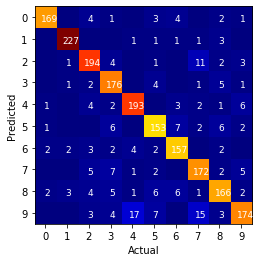

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline  

NUM_LABELS = 10  # change it according to num_class in your dataset
test_error, confusions = error_rate(numpy.asarray(preds), numpy.asarray(labels))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

### Delete Endpoint
Once you are done using the endpoint, you can use the following to delete it. 

In [35]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '70145705-2a56-4009-bc50-27e97a7396b3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '70145705-2a56-4009-bc50-27e97a7396b3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 27 Sep 2020 19:17:40 GMT'},
  'RetryAttempts': 0}}